**Why sarcasm is a problem?**

Sarcasm can be a challenge in natural language processing tasks because it often involves the use of irony or other types of nuanced language that may not be detected by standard text analysis tools. Furthermore, the sentiment (positive or negative) of a sarcastic sentence is often the opposite of its literal meaning, which can lead to incorrect interpretation. **This makes it difficult for machines to accurately understand and respond to sarcastic statements**.

AutoKeras is an open-source Python library for automated machine learning (AutoML). It provides automated solutions for several ML tasks, like image classification, text classification, regression, etc. It was built on top of Keras, a user-friendly neural network library in Python. AutoKeras aims to **make machine learning accessible for everyone and reduce the amount of time and effort required to design a model**.

TextClassifier in AutoKeras is a**n automated model search class specifically for text classification tasks**. Given a dataset of text and their corresponding labels, the TextClassifier **searches over different models** (combinations of pre-processing steps, architectures, and hyperparameters), and **identifies the model that performs best on the given task**. This involves several aspects, such as **tokenization, embedding, and the design of the neural network itself**.


This dataset overcomes limitations found in Twitter datasets, such as noise in labels and language, as well as the need for context to understand sarcasm in many tweets. **The advantages of this new dataset include the quality of writing** (headlines written by professionals without spelling errors and informal language), high quality labels with less noise, and the independence of the collected headlines.

Each record consists of three attributes:

- **is_sarcastic**: 1 if the record is sarcastic otherwise 0

- **headline**: the headline of the news article

- **article_link**: link to the original news article. Useful in collecting supplementary data

In [1]:
!pip install autocorrect
!pip install inflect
!pip install autokeras

In [2]:
import numpy as np 
import pandas as pd 
import dask.dataframe as dd
import nltk
import re
import inflect
import tensorflow as tf
import autokeras as ak
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import requests

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from io import BytesIO
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from autocorrect import Speller
from dask.diagnostics import ProgressBar
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# image to maks in word cloud
url1 = "https://i.pinimg.com/originals/57/d3/14/57d3143cf859da58fd366e6fc639bbe6.png"
url2 = "https://i.pinimg.com/originals/51/be/ca/51becaed84a445a690d681abe3af880b.png"

response1 = requests.get(url1)
response2 = requests.get(url2)

sarcastic_mask = np.array(Image.open(BytesIO(response1.content)))
non_sarcastic_mask = np.array(Image.open(BytesIO(response2.content)))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
address = "/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json"
json_df = pd.read_json(address,lines = True )
df_sarcasm = pd.DataFrame(json_df)

df_sarcasm.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
df_sarcasm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [5]:
# Drop column article_link
df_sarcasm = df_sarcasm.drop("article_link", axis = 1)

In [6]:
# Show rows duplicated
df_sarcasm.duplicated().sum()

116

In [7]:
# Drop rows duplicated
df_sarcasm.drop_duplicates(subset=['headline'], inplace = True)
df_sarcasm.duplicated().sum()

0

In [8]:
# Inicializate spelling correction, stemmer, and number to words converter
nltk.download('wordnet')
nltk.download('stopwords')
spell = Speller(lang='en')
stemmer = SnowballStemmer(language='english')
stop_words = set(stopwords.words('english'))
p = inflect.engine()

# Cache for common words
word_cache = {}

def preprocess_text(text):
    """
    Function to preprocess text data. This involves several steps:
    1. Convert text to lowercase.
    2. Remove special characters from the text, convert numbers to words.
    3. Remove extra spaces from the text.
    4. Perform tokenization - split the text into individual words.
    5. Remove stop words - common words that do not contribute much to the meaning of the text.
    6. Perform stemming - reduce words to their root form.
    7. Perform spelling correction.

    Parameters:
    text (str): The text data to be preprocessed.

    Returns:
    str: The preprocessed text.
    """
    text = text.lower()
    text = re.sub(r'\d+', lambda x: p.number_to_words(x.group()), text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub('\s+', ' ', text).strip()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words] 
    # Use cached word if it exists, else spell correct and store in cache
    words = [word_cache.get(word, word_cache.setdefault(word, spell(word))) for word in words]

    return ' '.join(words)

# DataFrame to Dask DataFrame
ddf = dd.from_pandas(df_sarcasm, npartitions=10)

# Dask's map_partitions function to apply the preprocess function to the 'headline' column
# map_partitions applies a function to each partition of the DataFrame
with ProgressBar():
    ddf['cleaned_headline'] = ddf['headline'].map_partitions(lambda df: df.apply(preprocess_text)).compute(scheduler='threads')

# Convert the Dask back to DataFrame
df_sarcasm = ddf.compute()

# Show dataframe modificaed
df_sarcasm.head()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[########################################] | 100% Completed | 35m 20s


,is_sarcastic,headline,cleaned_headline
0,1,thirtysomething scientists unveil doomsday clo...,thirtysometh scientist unveil doomsday clock h...
1,0,dem rep. totally nails why congress is falling...,dem rep total nail congress fall short gender ...
2,0,eat your veggies: 9 deliciously different recipes,eat eggs nine device differ recap
3,1,inclement weather prevents liar from getting t...,inclement weather prevent liar get work
4,1,mother comes pretty close to using word 'strea...,mother come pretty close use word stream correct


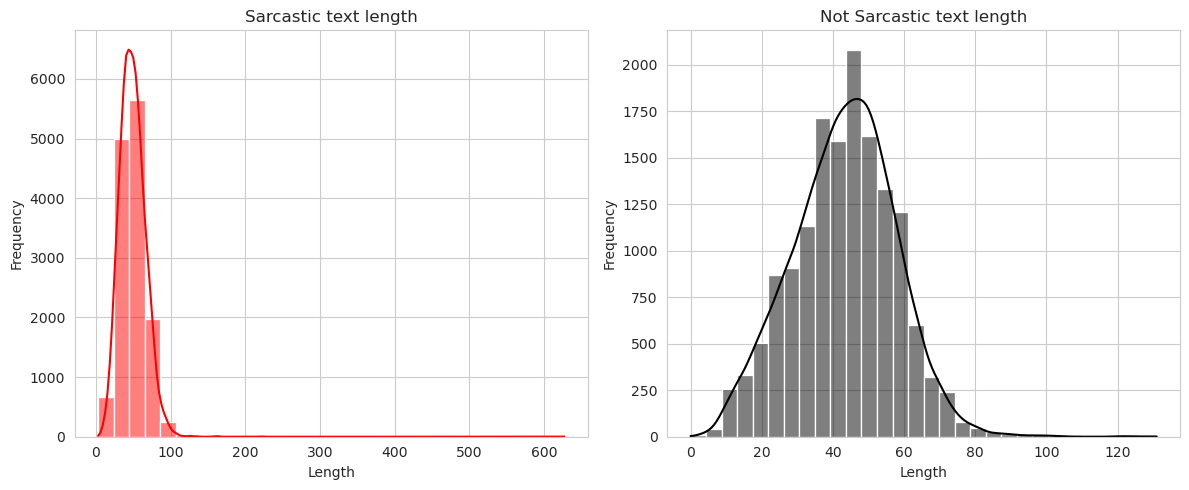

In [9]:
df_sarcasm['text_len'] = df_sarcasm['cleaned_headline'].apply(len)
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograma sarcasm
sns.histplot(data=df_sarcasm[df_sarcasm['is_sarcastic']==1], 
             x='text_len', 
             color='red', 
             ax=ax[0], 
             kde=True, 
             bins=30)

ax[0].set_title('Sarcastic text length')
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Frequency')

# Plot histofram no sarcasm
sns.histplot(data=df_sarcasm[df_sarcasm['is_sarcastic']==0],
             x='text_len',
             color='black', 
             ax=ax[1], 
             kde=True, 
             bins=30)

ax[1].set_title('Not Sarcastic text length')
ax[1].set_xlabel('Length')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

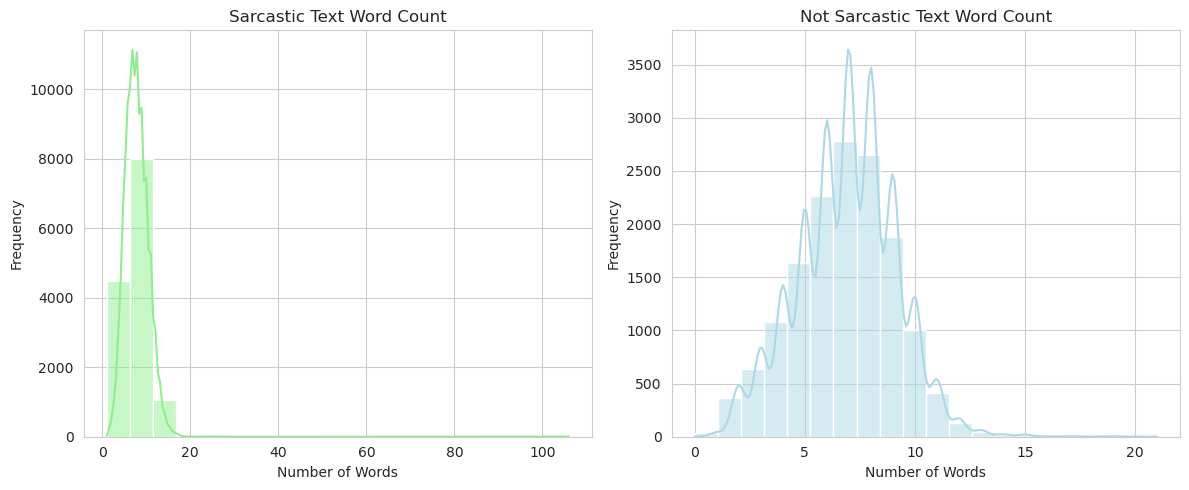

In [10]:
df_sarcasm['word_count'] = df_sarcasm['cleaned_headline'].str.split().map(lambda x: len(x))
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Histogram do number of words on title sarcasm
sns.histplot(data=df_sarcasm[df_sarcasm['is_sarcastic']==1], 
             x='word_count', 
             color='lightgreen', 
             ax=ax[0], 
             kde=True, 
             bins=20)

ax[0].set_title('Sarcastic Text Word Count')
ax[0].set_xlabel('Number of Words')
ax[0].set_ylabel('Frequency')

# Histogram number of words on title not sarcasm
sns.histplot(data=df_sarcasm[df_sarcasm['is_sarcastic']==0], 
             x='word_count', 
             color='lightblue', 
             ax=ax[1], 
             kde=True, 
             bins=20)

ax[1].set_title('Not Sarcastic Text Word Count')
ax[1].set_xlabel('Number of Words')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

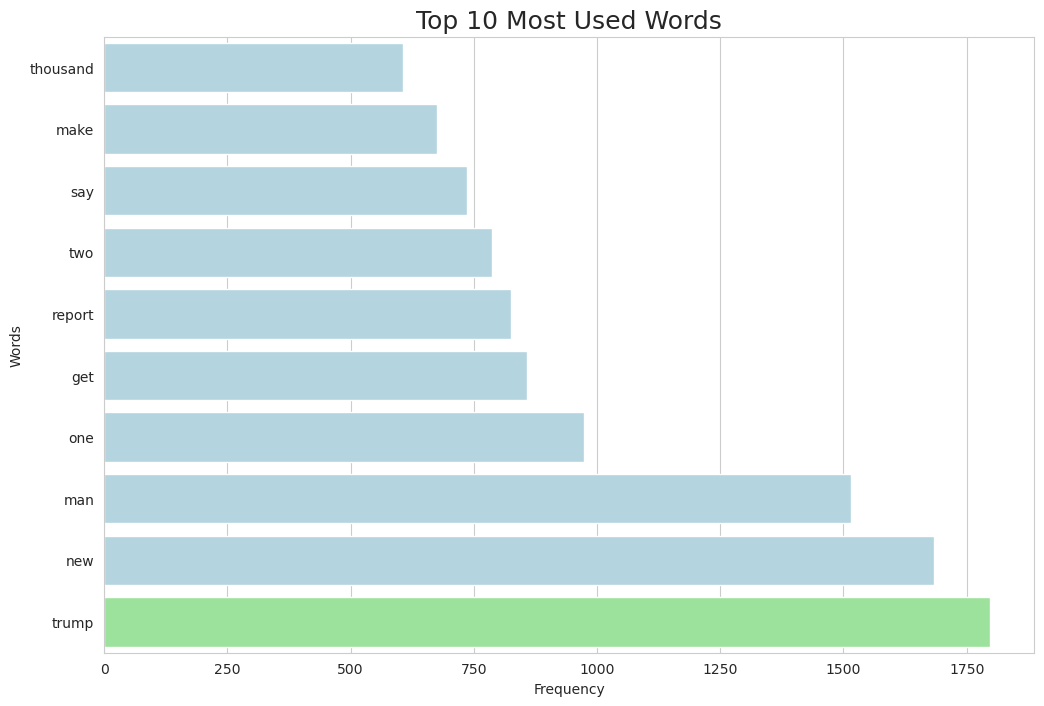

In [11]:
words = []
for text in df_sarcasm['cleaned_headline']:
    words.extend(text.split())
word_count = collections.Counter(words)

top_words = dict(word_count.most_common(10))
words_df = pd.DataFrame(list(top_words.keys()), columns=['words'])
count_df = pd.DataFrame(list(top_words.values()), columns=['count'])
top_words_df = pd.concat([words_df, count_df], axis=1)
top_words_df = top_words_df.sort_values('count')
plt.figure(figsize=(12, 8))
mask = top_words_df['words'] == top_words_df.loc[top_words_df['count'].idxmax(), 'words']
sns.barplot(x='count', 
            y='words', 
            data=top_words_df, 
            palette=mask.map({True: 'lightgreen', False: 'lightblue'}))

plt.title('Top 10 Most Used Words', fontsize=18)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

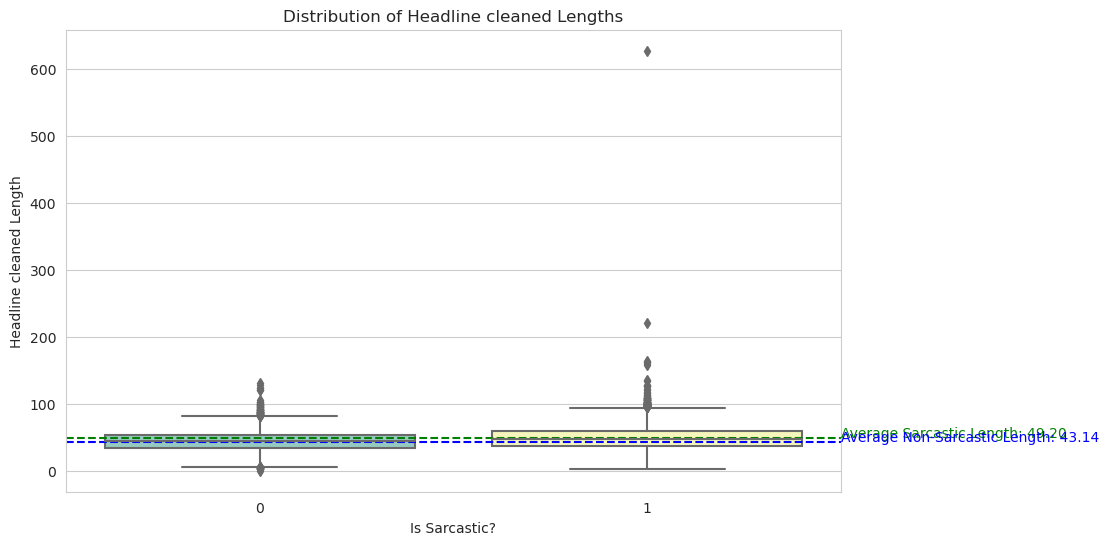

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_sarcastic', y='text_len', data=df_sarcasm, palette='Set3')
mean_length_sarcastic = df_sarcasm[df_sarcasm['is_sarcastic'] == 1]['text_len'].mean()
mean_length_non_sarcastic = df_sarcasm[df_sarcasm['is_sarcastic'] == 0]['text_len'].mean()

plt.axhline(mean_length_sarcastic, color='green', linestyle='--')
plt.axhline(mean_length_non_sarcastic, color='blue', linestyle='--')
plt.text(1.5, mean_length_sarcastic, 
         'Average Sarcastic Length: {:.2f}'.format(mean_length_sarcastic), 
         color='green')

plt.text(1.5, mean_length_non_sarcastic, 
         'Average Non-Sarcastic Length: {:.2f}'.format(mean_length_non_sarcastic), 
         color='blue')

plt.xlabel('Is Sarcastic?')
plt.ylabel('Headline cleaned Length')
plt.title('Distribution of Headline cleaned Lengths')
plt.show()

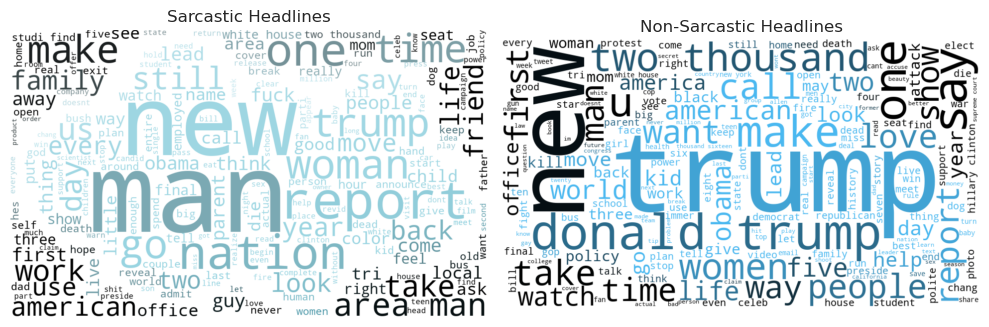

In [13]:
sarcastic_text = ' '.join(df_sarcasm[df_sarcasm['is_sarcastic'] == 1]['cleaned_headline'])
non_sarcastic_text = ' '.join(df_sarcasm[df_sarcasm['is_sarcastic'] == 0]['cleaned_headline'])

sarcastic_colors = ImageColorGenerator(sarcastic_mask)

non_sarcastic_colors = ImageColorGenerator(non_sarcastic_mask)
wordcloud_sarcastic = WordCloud(mask=sarcastic_mask, 
                                background_color="white", 
                                contour_color='black').generate(sarcastic_text)

wordcloud_non_sarcastic = WordCloud(mask=non_sarcastic_mask, 
                                    background_color="white", 
                                    contour_color='black').generate(non_sarcastic_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_sarcastic.recolor(color_func=sarcastic_colors), interpolation='bilinear')
plt.title('Sarcastic Headlines')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_sarcastic.recolor(color_func=non_sarcastic_colors), interpolation='bilinear')
plt.title('Non-Sarcastic Headlines')
plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(df_sarcasm.cleaned_headline), 
                                                  np.array(df_sarcasm.is_sarcastic), 
                                                  test_size=0.2, 
                                                  stratify=np.array(df_sarcasm.is_sarcastic), 
                                                  random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, 
                                                  y_temp, 
                                                  test_size=0.25,
                                                  stratify=y_temp, 
                                                  random_state=42)

In [15]:
clf = ak.TextClassifier(
    num_classes=2,
    multi_label=False,
    max_trials=3,# Number of different models to try (you can modify to use many models)
    loss='binary_crossentropy', 
    objective='val_accuracy',  
    seed=42 
)  

result_training = clf.fit(X_train, 
                          y_train, 
                          epochs=3, 
                          validation_split=0.2, 
                          validation_data=(X_val, y_val))

predicted_y = clf.predict(X_test)

Trial 3 Complete [01h 16m 52s]
val_accuracy: 0.7907384634017944

Best val_accuracy So Far: 0.7907384634017944
Total elapsed time: 01h 18m 31s
Epoch 1/3
Not enough memory, reduce batch size to 16.
Epoch 1/3
Not enough memory, reduce batch size to 8.
Epoch 1/3
2138/2138 [==============================] - 1438s 663ms/step - loss: 0.4955 - accuracy: 0.7477 - val_loss: 0.4511 - val_accuracy: 0.7876
Epoch 2/3
2138/2138 [==============================] - 1414s 661ms/step - loss: 0.3790 - accuracy: 0.8305 - val_loss: 0.4511 - val_accuracy: 0.7876
Epoch 3/3
179/179 [==============================] - 134s 746ms/step


In [47]:
def plot_graphs(history, string):
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')
    
    if string in history.history:
        plt.figure(figsize=(12,6))    
        plt.plot(history.history[string], marker='o', color=palette[2], linewidth=2.5, label=string)
        
        if 'val_'+string in history.history:
            plt.plot(history.history['val_'+string], marker='o', color=palette[4], linewidth=2.5, label='val_'+string)
        
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel(string, fontsize=12)
        plt.title('Training and Validation '+string.title(), fontsize=14)
        plt.legend(fontsize=12)
        
        plt.ylim([0,1])
        plt.grid(True)

        plt.show()
    else:
        print(f"{string} not in history.")

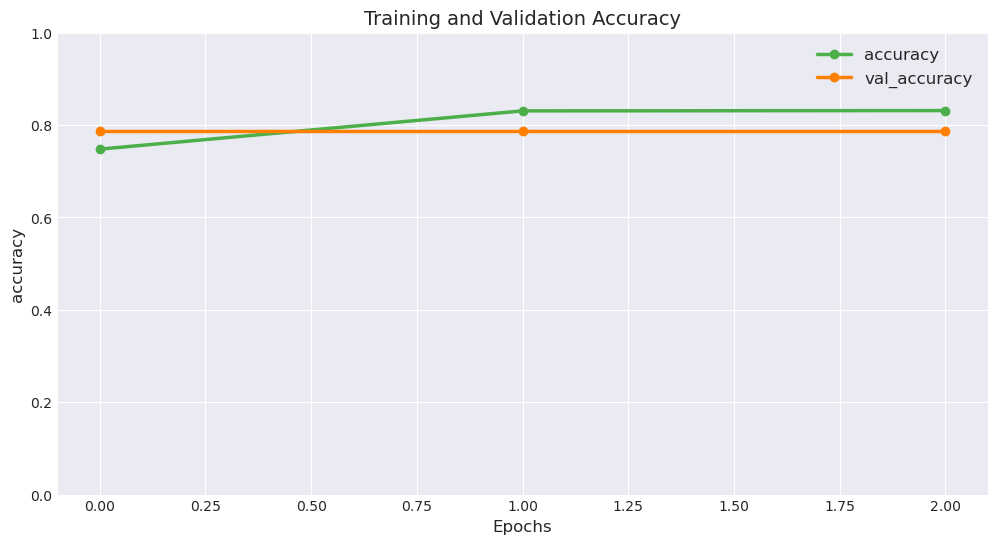

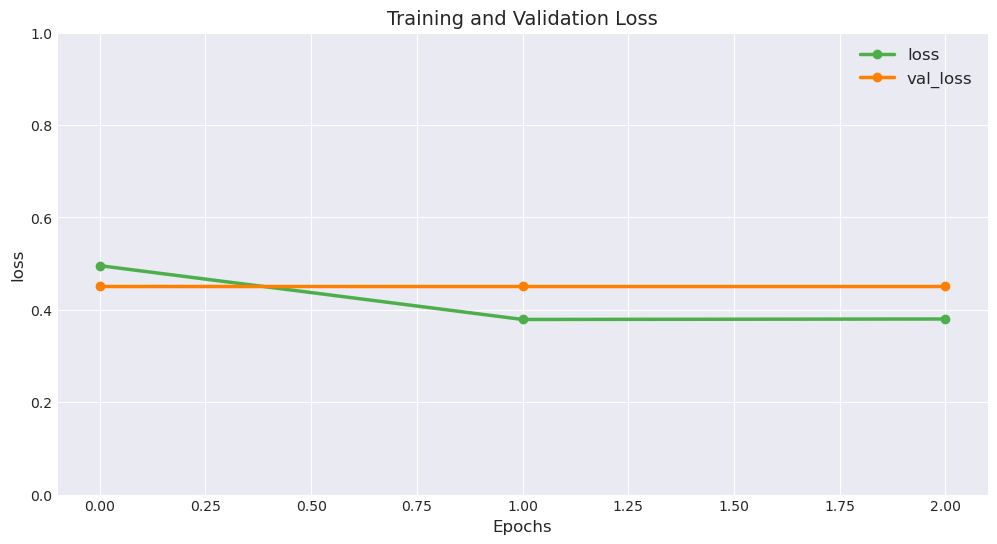

In [48]:
plot_graphs(result_training, "accuracy")
plot_graphs(result_training, "loss")

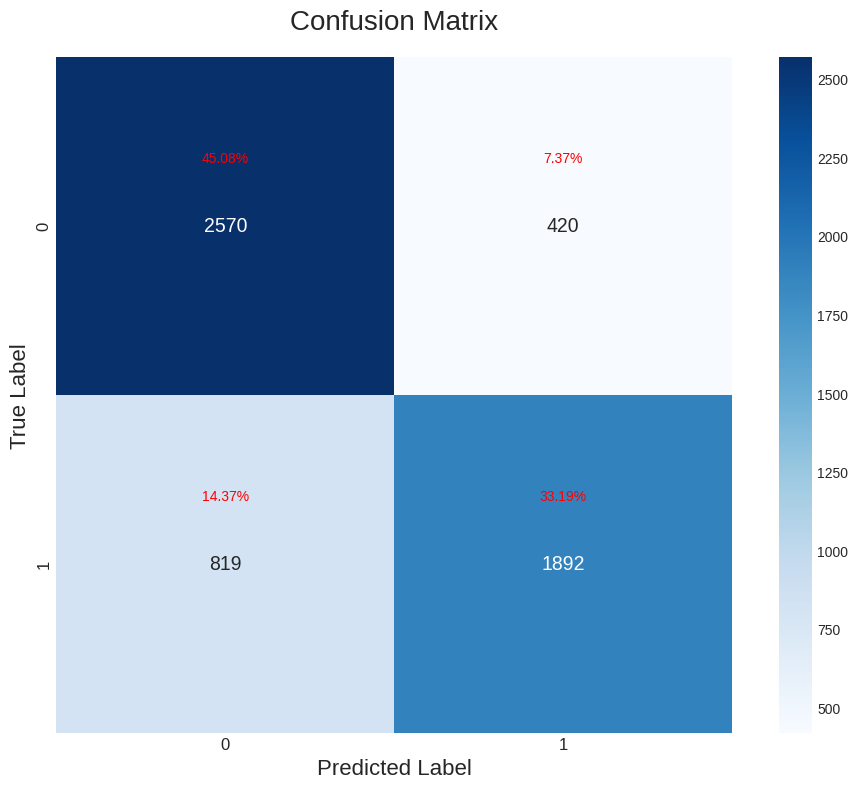

In [46]:
cm = confusion_matrix(y_test, predicted_y)
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, annot_kws={"size": 14})

# Add percent of confusion matrix
total = np.sum(cm)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        percentage = f'{100 * cm[i, j] / total:.2f}%'
        plt.text(j + 0.5, i + 0.3, percentage, horizontalalignment='center', verticalalignment='center', color='red')

heatmap.set_xlabel('Predicted Label', fontsize=16)
heatmap.set_ylabel('True Label', fontsize=16)
heatmap.set_title('Confusion Matrix', pad=20, fontsize=20)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), fontsize=12)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), fontsize=12)

plt.tight_layout()
plt.show()

In [19]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      2990
           1       0.82      0.70      0.75      2711

    accuracy                           0.78      5701
   macro avg       0.79      0.78      0.78      5701
weighted avg       0.79      0.78      0.78      5701



In [44]:
def predict_sarcasm(text, model):
    preprocessed_text = [preprocess_text(text)]  # preprocess and wrap into list
    result = model.predict(np.array(preprocessed_text))  # predict using model
    if result[0] == 0:
        print("The sentence: '{}' was not considered sarcastic.".format(text))
    elif result[0] == 1:
        print("The sentence: '{}' was considered sarcastic.".format(text))

sarcasm = "Oh, wonderful! My computer crashes right before I save my work."
without_sarcasm = "I love spending time with my family during the holidays."

predict_sarcasm(sarcasm, clf)
predict_sarcasm(without_sarcasm, clf)

1/1 [==============================] - 0s 97ms/step
The sentence: 'Oh, wonderful! My computer crashes right before I save my work.' was considered sarcastic.
1/1 [==============================] - 0s 94ms/step
The sentence: 'I love spending time with my family during the holidays.' was not considered sarcastic.


Sarcasm detection is a complex task in NLP, **using state-of-the-art machine learning tools**, such as AutoKeras, can bring us closer to more accurate and effective solutions. It may open doors for future studies in the area, focusing on the application of these techniques and datasets in various NLP applications, such as **sentiment analysis, chatbots and customer service services**. Improved sarcasm detection will continue to be an important and challenging field for NLP research, **with significant practical implications for human communication and human-machine interaction**.